# Imports and parameters

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
import pandas as pd
from download import download_data_and_parse_it
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split
import time
import os


from sklearn.metrics import accuracy_score

batch_size = 32
num_classes = 12
learning_rate = 0.001
num_epochs = 10

# Create the model

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


class QuickDrawDataset(Dataset):
    def __init__(self, drawings, labels):
        self.drawings = drawings
        self.labels = labels
        
    def __len__(self):
        return len(self.drawings)
    
    def __getitem__(self, idx):
        # Convert the drawing format to image
        drawing = self.drawings.iloc[idx] if isinstance(self.drawings, pd.Series) else self.drawings[idx]
        image = self.drawing_to_image(drawing)
        label = self.labels.iloc[idx] if isinstance(self.labels, pd.Series) else self.labels[idx]
        return torch.FloatTensor(image).unsqueeze(0), label
    
    def drawing_to_image(self, drawing):
        # Create a blank 64x64 image
        image = np.zeros((64, 64))
        
        # For each stroke in the drawing
        for stroke in drawing:
            # Get x and y coordinates
            x = stroke[0]
            y = stroke[1]
            
            # Draw lines between consecutive points
            for i in range(len(x)-1):
                x1, y1 = int(x[i]), int(y[i])
                x2, y2 = int(x[i+1]), int(y[i+1])
                
                # Ensure points are within bounds
                x1 = max(0, min(x1, 63))
                y1 = max(0, min(y1, 63))
                x2 = max(0, min(x2, 63))
                y2 = max(0, min(y2, 63))
                
                # Draw line
                image[y1, x1] = 255
                image[y2, x2] = 255
        
        return image / 255.0
    
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(model)
    

Using cuda device
SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=12, bias=True)
  )
)


# Data

In [22]:
le = LabelEncoder()
# Load the JSON file into a DataFrame
datasets = [
        "star", "sword", "tent", "apple", "banana", "cat", 
        "dog", "car", "house", "tree", "guitar", "bicycle"
    ]
    
all_dfs = []  # List to store all DataFrames
for dataset in datasets:
    file_path = os.path.join("data", f"{dataset}.ndjson")
    dataset_df = download_data_and_parse_it(file_path)
    all_dfs.append(dataset_df)

# Combine all datasets into a single DataFrame
df = pd.concat(all_dfs, ignore_index=True)

# Assign class labels using LabelEncoder
le = LabelEncoder()
df['class'] = le.fit_transform(df['word'])

# Split into training and testing sets
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# # Create datasets
# train_dataset = QuickDrawDataset(train_df['drawing'], train_df['class'])
# test_dataset = QuickDrawDataset(test_df['drawing'], test_df['class'])

# Split into training, validation, and testing sets
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)  # 60% train, 40% temp
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # Split temp into 20% val, 20% test

# Create datasets
train_dataset = QuickDrawDataset(train_df['drawing'], train_df['class'])
val_dataset = QuickDrawDataset(val_df['drawing'], val_df['class'])
test_dataset = QuickDrawDataset(test_df['drawing'], test_df['class'])


# Create DataLoaders
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

The file exists.
        word countrycode                      timestamp  recognized  \
137609  star          US  2017-03-09 02:15:31.37731 UTC        True   
137610  star          US  2017-01-28 19:53:08.59709 UTC        True   
137611  star          IT  2017-01-27 19:27:41.85155 UTC        True   
137612  star          US  2017-01-28 03:53:15.71915 UTC        True   
137613  star          US  2017-03-08 02:15:13.19402 UTC        True   
137614  star          US  2017-03-17 00:47:57.91579 UTC        True   
137615  star          DE  2017-03-29 19:14:10.11319 UTC        True   
137616  star          FI  2017-01-29 14:59:06.09068 UTC        True   
137617  star          US  2017-03-23 03:38:30.79912 UTC        True   
137618  star          CA  2017-03-28 00:38:35.24141 UTC        True   

                  key_id                                            drawing  
137609  5367371076206592  [[[176, 165, 163, 160, 151, 132, 130, 107, 79,...  
137610  5195486589878272  [[[13, 13, 29, 57, 

In [23]:
# Training loop
def train_model(model):
    model.train()
    for epoch in range(num_epochs):  # Number of epochs
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

# Testing loop
def test_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")


In [19]:
start_time = time.time()

train_model(model)
test_model(model)

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

Epoch 1, Loss: 1.480605355513433
Epoch 2, Loss: 1.4067142316986643
Epoch 3, Loss: 1.3829655138757095
Epoch 4, Loss: 1.3683869461317484
Epoch 5, Loss: 1.3568769676445935
Epoch 6, Loss: 1.3469180879488998
Epoch 7, Loss: 1.3382936690886336
Epoch 8, Loss: 1.330497174981958


KeyboardInterrupt: 

# Automation

## Define the models

[I 2024-12-28 20:03:10,922] A new study created in memory with name: no-name-da72eca8-b385-4f43-b1cb-62fbc3bdb686
[I 2024-12-28 20:08:55,174] Trial 0 finished with value: 0.7119480849980914 and parameters: {'conv_layers': [32, 64], 'kernel_size': 5, 'learning_rate': 0.00097973840786045}. Best is trial 0 with value: 0.7119480849980914.
/home/quentin/BigData/.venv/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 32] which is of type list.
  warnings.warn(message)
/home/quentin/BigData/.venv/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 32, 64] which is of type list.
  warnings.warn(message)
/home/quentin/BigData/.venv/lib/python3.12/site-packages/optuna/distributions.py:524: UserWar

Execution time: 418.718310 seconds
Best trial:
  Value: 0.7145056622980023
  Params:
    conv_layers: [16, 32, 64]
    kernel_size: 5
    learning_rate: 0.0001365409402313865


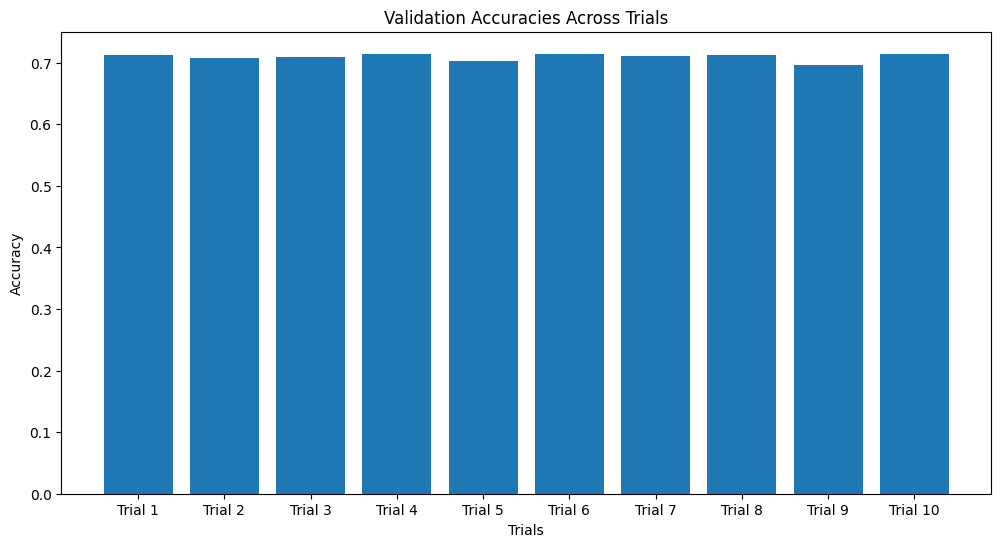

In [36]:
# Define the dataset (dummy data for illustration)
class QuickDrawDataset(Dataset):
    def __init__(self, drawings, labels):
        self.drawings = drawings
        self.labels = labels

    def __len__(self):
        return len(self.drawings)

    def __getitem__(self, idx):
        drawing = self.drawings.iloc[idx]
        image = self.drawing_to_image(drawing)
        label = self.labels.iloc[idx]
        return torch.FloatTensor(image).unsqueeze(0), label

    def drawing_to_image(self, drawing):
        # Create a blank 64x64 image
        image = np.zeros((64, 64))
        
        # For each stroke in the drawing
        for stroke in drawing:
            # Get x and y coordinates
            x = stroke[0]
            y = stroke[1]
            
            # Draw lines between consecutive points
            for i in range(len(x)-1):
                x1, y1 = int(x[i]), int(y[i])
                x2, y2 = int(x[i+1]), int(y[i+1])
                
                # Ensure points are within bounds
                x1 = max(0, min(x1, 63))
                y1 = max(0, min(y1, 63))
                x2 = max(0, min(x2, 63))
                y2 = max(0, min(y2, 63))
                
                # Draw line
                image[y1, x1] = 255
                image[y2, x2] = 255

# Define a dynamic model class
def create_model(conv_layers, kernel_size, learning_rate, num_classes=10):
    class CustomCNN(nn.Module):
        def __init__(self):
            super(CustomCNN, self).__init__()
            layers = []
            in_channels = 1
            size = 64  # Initial image size
            for out_channels in conv_layers:
                layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1))
                layers.append(nn.ReLU())
                layers.append(nn.MaxPool2d(2))  # MaxPool2d halves the size
                in_channels = out_channels
                size = size // 2  # Each MaxPool2d halves the size
            
            self.conv_layers = nn.Sequential(*layers)

            # Dynamically calculate the output size after convolutions and pooling
            # Pass a dummy tensor through the convolution layers to get the output size
            with torch.no_grad():
                dummy_input = torch.zeros(1, 1, 64, 64)  # (batch_size, channels, height, width)
                output_size = self.conv_layers(dummy_input)
                # Output size is [batch_size, channels, height, width]
                final_size = output_size.view(1, -1).size(1)

            # Fully connected layers
            self.fc_layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(final_size, 128),
                nn.ReLU(),
                nn.Linear(128, num_classes)
            )

        def forward(self, x):
            x = self.conv_layers(x)
            x = self.fc_layers(x)
            return x

    return CustomCNN()

# Train and evaluate a model
def train_and_evaluate(config, train_loader, val_loader, device):
    model = create_model(config["conv_layers"], config["kernel_size"], config["learning_rate"], num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = nn.CrossEntropyLoss()

    train_losses, val_accuracies = [], []
    for epoch in range(5):  # Keep epochs small for testing
        model.train()
        epoch_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_preds.extend(outputs.argmax(dim=1).tolist())
                val_labels.extend(labels.tolist())
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_accuracies.append(val_accuracy)

    return train_losses, val_accuracies

# Define the Optuna objective function
def objective(trial):
    conv_layers = trial.suggest_categorical("conv_layers", [[16, 32], [16, 32, 64], [32, 64]])
    kernel_size = trial.suggest_int("kernel_size", 3, 5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    config = {
        "conv_layers": conv_layers,
        "kernel_size": kernel_size,
        "learning_rate": learning_rate
    }

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    _, val_accuracies = train_and_evaluate(config, train_loader, val_loader, device)
    return max(val_accuracies)

# Run Optuna study
start_study_time = time.time()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

end_study_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

# Retrieve best results
best_trial = study.best_trial
print("Best trial:")
print(f"  Value: {best_trial.value}")
print("  Params:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Visualization
trials = study.trials
val_accuracies = [trial.value for trial in trials]
configs = [trial.params for trial in trials]

# Plot results
plt.figure(figsize=(12, 6))
plt.bar(range(len(configs)), val_accuracies, tick_label=[f"Trial {i + 1}" for i in range(len(configs))])
plt.title("Validation Accuracies Across Trials")
plt.xlabel("Trials")
plt.ylabel("Accuracy")
plt.show()

[I 2024-12-29 08:41:50,438] A new study created in memory with name: no-name-678940ed-ed5a-4ddf-9692-6dadd31e9dfa
/home/quentin/BigData/.venv/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 32] which is of type list.
  warnings.warn(message)
/home/quentin/BigData/.venv/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 32, 64] which is of type list.
  warnings.warn(message)
/home/quentin/BigData/.venv/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [32, 64] which is of type list.
  warnings.warn(message)
/home/quentin/BigData/.venv/lib/p

Best trial:
  Value: 0.7183992874411502
  Params:
    conv_layers: [16, 64, 128, 256]
    kernel_size: 5
    learning_rate: 0.0006432500821860962


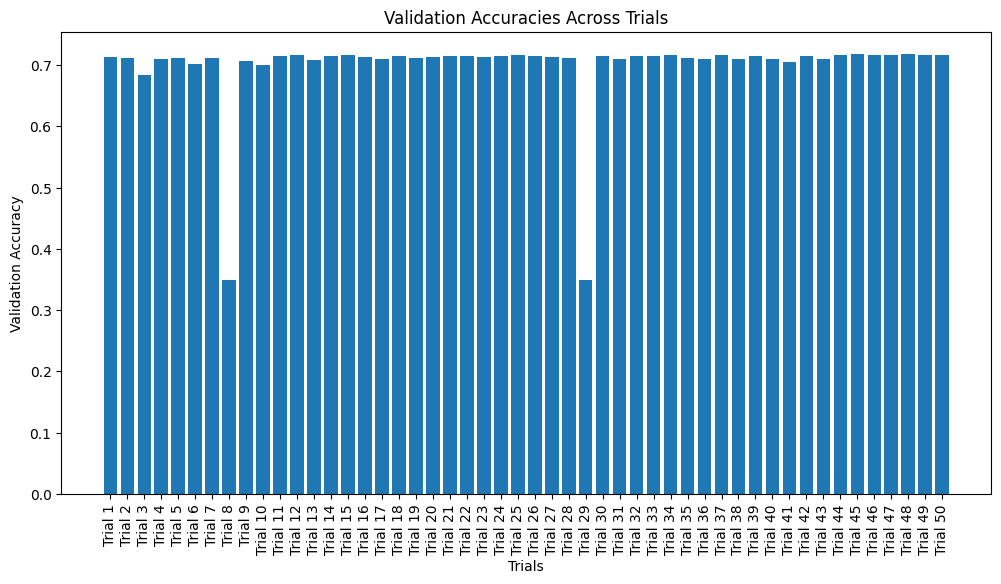

In [39]:
# Define the dataset (dummy data for illustration)
class QuickDrawDataset(Dataset):
    def __init__(self, drawings, labels):
        self.drawings = drawings
        self.labels = labels

    def __len__(self):
        return len(self.drawings)

    def __getitem__(self, idx):
        drawing = self.drawings.iloc[idx]
        image = self.drawing_to_image(drawing)
        label = self.labels.iloc[idx]
        return torch.FloatTensor(image).unsqueeze(0), label

    def drawing_to_image(self, drawing):
        # Create a blank 64x64 image
        image = np.zeros((64, 64))
        
        # For each stroke in the drawing
        for stroke in drawing:
            # Get x and y coordinates
            x = stroke[0]
            y = stroke[1]
            
            # Draw lines between consecutive points
            for i in range(len(x)-1):
                x1, y1 = int(x[i]), int(y[i])
                x2, y2 = int(x[i+1]), int(y[i+1])
                
                # Ensure points are within bounds
                x1 = max(0, min(x1, 63))
                y1 = max(0, min(y1, 63))
                x2 = max(0, min(x2, 63))
                y2 = max(0, min(y2, 63))
                
                # Draw line
                image[y1, x1] = 255
                image[y2, x2] = 255

# Define a dynamic model class
def create_model(conv_layers, kernel_size, learning_rate, num_classes=10):
    class CustomCNN(nn.Module):
        def __init__(self):
            super(CustomCNN, self).__init__()
            layers = []
            in_channels = 1
            size = 64  # Initial image size
            for out_channels in conv_layers:
                layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1))
                layers.append(nn.ReLU())
                layers.append(nn.MaxPool2d(2))  # MaxPool2d halves the size
                in_channels = out_channels
                size = size // 2  # Each MaxPool2d halves the size
            
            self.conv_layers = nn.Sequential(*layers)

            # Dynamically calculate the output size after convolutions and pooling
            # Pass a dummy tensor through the convolution layers to get the output size
            with torch.no_grad():
                dummy_input = torch.zeros(1, 1, 64, 64)  # (batch_size, channels, height, width)
                output_size = self.conv_layers(dummy_input)
                # Output size is [batch_size, channels, height, width]
                final_size = output_size.view(1, -1).size(1)

            # Fully connected layers
            self.fc_layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(final_size, 128),
                nn.ReLU(),
                nn.Linear(128, num_classes)
            )

        def forward(self, x):
            x = self.conv_layers(x)
            x = self.fc_layers(x)
            return x

    return CustomCNN()

# Train and evaluate a model
def train_and_evaluate(config, train_loader, val_loader, device):
    try:
        # Create and initialize the model
        model = create_model(config["conv_layers"], config["kernel_size"], config["learning_rate"], num_classes=num_classes).to(device)
        optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
        criterion = nn.CrossEntropyLoss()

        train_losses, val_accuracies = [], []
        for epoch in range(5):  # Keep epochs small for testing
            model.train()
            epoch_loss = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            train_losses.append(epoch_loss / len(train_loader))

            # Validation
            model.eval()
            val_preds, val_labels = [], []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    val_preds.extend(outputs.argmax(dim=1).tolist())
                    val_labels.extend(labels.tolist())
            val_accuracy = accuracy_score(val_labels, val_preds)
            val_accuracies.append(val_accuracy)

        return train_losses, val_accuracies
    
    except RuntimeError as e:
        print(f"RuntimeError encountered: {e}")
        return None, None
    except ValueError as e:
        print(f"ValueError encountered: {e}")
        return None, None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None, None


def objective(trial):
    # Expand the conv_layers options to have more combinations
    conv_layers = trial.suggest_categorical("conv_layers", [
        [16, 32], 
        [16, 32, 64], 
        [32, 64], 
        [64, 128], 
        [16, 64, 128],
        [32, 64, 128],
        [16, 64, 128, 256],
    ])
    
    # Expand the kernel size range to try 3, 5, and 7
    kernel_size = trial.suggest_int("kernel_size", 3, 5)
    
    # Extend the learning rate range for wider exploration
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)

    # Configuration dictionary for the trial
    config = {
        "conv_layers": conv_layers,
        "kernel_size": kernel_size,
        "learning_rate": learning_rate
    }

    # DataLoader and training setup as before
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Train and evaluate the model
    _, val_accuracies = train_and_evaluate(config, train_loader, val_loader, device)
    
    # Return the best validation accuracy achieved in this trial
    return max(val_accuracies)

# Create a study and run the optimization with more trials (50 in total)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Retrieve the best trial and print its results
best_trial = study.best_trial
print("Best trial:")
print(f"  Value: {best_trial.value}")
print("  Params:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Visualization
trials = study.trials
val_accuracies = [trial.value for trial in trials]
configs = [trial.params for trial in trials]

plt.figure(figsize=(12, 6))
plt.bar(range(len(configs)), val_accuracies, tick_label=[f"Trial {i + 1}" for i in range(len(configs))])
plt.title("Validation Accuracies Across Trials")
plt.xlabel("Trials")
plt.ylabel("Validation Accuracy")
plt.xticks(rotation=90)
plt.show()

## Go Further into conv_layers and fix learning rate to 0.005

[I 2024-12-29 12:10:35,848] A new study created in memory with name: no-name-ca8d4972-b1b9-4d43-afd8-5d52c9ca46e3
/home/quentin/BigData/.venv/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 64, 128, 256] which is of type list.
  warnings.warn(message)
/home/quentin/BigData/.venv/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [32, 64, 128, 256] which is of type list.
  warnings.warn(message)
/home/quentin/BigData/.venv/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 128, 256] which is of type list.
  warnings.warn(message)
/home/quent

RuntimeError encountered: Calculated padded input size per channel: (4 x 4). Kernel size: (5 x 5). Kernel size can't be greater than actual input size
Best trial:
  Value: 0.7209314162107139
  Params:
    conv_layers: [16, 32, 64, 128, 256]
    kernel_size: 3


TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

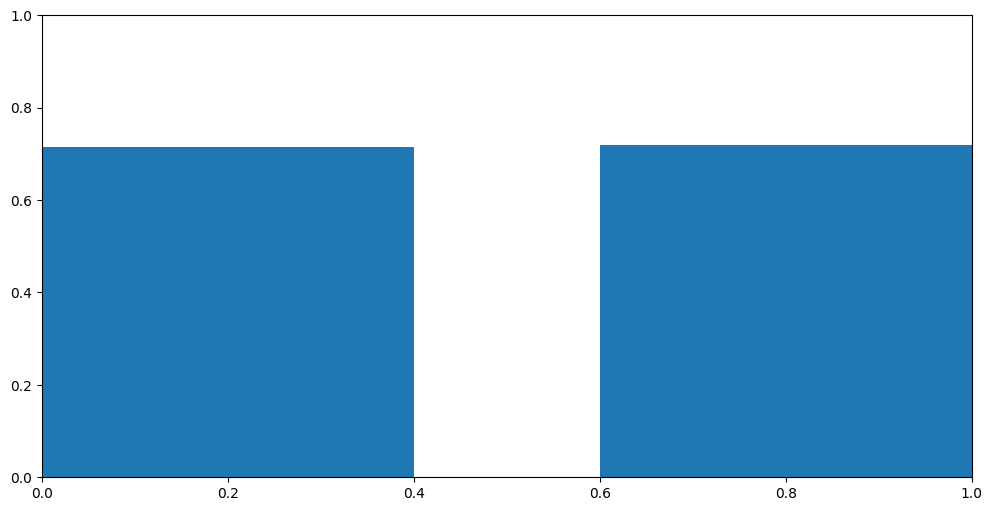

In [40]:
# Define the dataset (dummy data for illustration)
class QuickDrawDataset(Dataset):
    def __init__(self, drawings, labels):
        self.drawings = drawings
        self.labels = labels

    def __len__(self):
        return len(self.drawings)

    def __getitem__(self, idx):
        drawing = self.drawings.iloc[idx]
        image = self.drawing_to_image(drawing)
        label = self.labels.iloc[idx]
        return torch.FloatTensor(image).unsqueeze(0), label

    def drawing_to_image(self, drawing):
        # Create a blank 64x64 image
        image = np.zeros((64, 64))
        
        # For each stroke in the drawing
        for stroke in drawing:
            # Get x and y coordinates
            x = stroke[0]
            y = stroke[1]
            
            # Draw lines between consecutive points
            for i in range(len(x)-1):
                x1, y1 = int(x[i]), int(y[i])
                x2, y2 = int(x[i+1]), int(y[i+1])
                
                # Ensure points are within bounds
                x1 = max(0, min(x1, 63))
                y1 = max(0, min(y1, 63))
                x2 = max(0, min(x2, 63))
                y2 = max(0, min(y2, 63))
                
                # Draw line
                image[y1, x1] = 255
                image[y2, x2] = 255

# Define a dynamic model class
def create_model(conv_layers, kernel_size, learning_rate, num_classes=10):
    class CustomCNN(nn.Module):
        def __init__(self):
            super(CustomCNN, self).__init__()
            layers = []
            in_channels = 1
            size = 64  # Initial image size
            for out_channels in conv_layers:
                layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1))
                layers.append(nn.ReLU())
                layers.append(nn.MaxPool2d(2))  # MaxPool2d halves the size
                in_channels = out_channels
                size = size // 2  # Each MaxPool2d halves the size
            
            self.conv_layers = nn.Sequential(*layers)

            # Dynamically calculate the output size after convolutions and pooling
            # Pass a dummy tensor through the convolution layers to get the output size
            with torch.no_grad():
                dummy_input = torch.zeros(1, 1, 64, 64)  # (batch_size, channels, height, width)
                output_size = self.conv_layers(dummy_input)
                # Output size is [batch_size, channels, height, width]
                final_size = output_size.view(1, -1).size(1)

            # Fully connected layers
            self.fc_layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(final_size, 128),
                nn.ReLU(),
                nn.Linear(128, num_classes)
            )

        def forward(self, x):
            x = self.conv_layers(x)
            x = self.fc_layers(x)
            return x

    return CustomCNN()

# Train and evaluate the model
def train_and_evaluate(config, train_loader, val_loader, device):
    try:
        model = create_model(
            config["conv_layers"], 
            config["kernel_size"], 
            config["learning_rate"], 
            num_classes=num_classes
        ).to(device)
        optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
        criterion = nn.CrossEntropyLoss()

        train_losses, val_accuracies = [], []
        for epoch in range(5):  # Keep epochs small for testing
            model.train()
            epoch_loss = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            train_losses.append(epoch_loss / len(train_loader))

            # Validation
            model.eval()
            val_preds, val_labels = [], []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    val_preds.extend(outputs.argmax(dim=1).tolist())
                    val_labels.extend(labels.tolist())
            val_accuracy = accuracy_score(val_labels, val_preds)
            val_accuracies.append(val_accuracy)

        return train_losses, val_accuracies

    except Exception as e:
        print(f"Trial failed with error: {e}")
        # Return default losses and accuracies for failed trials
        return [], [0]  # Default to 0 accuracy for failed trials


def objective(trial):
    # Expand the conv_layers options to have more combinations
    conv_layers = trial.suggest_categorical("conv_layers", [
        [16, 64, 128, 256],
        [32, 64, 128, 256],   # New: Balanced increase in depth
        [64, 128, 256],       # New: Focus on mid-large channels
        [16, 32, 64, 128, 256], # New: Very deep architecture
        [8, 16, 32],          # New: Lightweight model
        [128, 256, 512],      # New: Heavyweight architecture
        [16, 128, 256],       # New: Mixed light-heavy combination
    ])
    
    # Fix the kernel size to a range
    kernel_size = trial.suggest_int("kernel_size", 3, 5)

    # Fixed learning rate
    learning_rate = 0.0005

    # Configuration dictionary for the trial
    config = {
        "conv_layers": conv_layers,
        "kernel_size": kernel_size,
        "learning_rate": learning_rate
    }

    # DataLoader and training setup as before
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Train and evaluate the model
    _, val_accuracies = train_and_evaluate(config, train_loader, val_loader, device)
    if val_accuracies is None:
        raise optuna.exceptions.TrialPruned()
    
    # Return the best validation accuracy achieved in this trial
    return max(val_accuracies)

# Create a study and run the optimization with more trials (50 in total)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Retrieve the best trial and print its results
best_trial = study.best_trial
print("Best trial:")
print(f"  Value: {best_trial.value}")
print("  Params:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Visualization
trials = study.trials
val_accuracies = [trial.value for trial in trials]
configs = [trial.params for trial in trials]

# Filter out trials with None in val_accuracies
valid_trials = [(i, acc) for i, acc in enumerate(val_accuracies) if acc is not None]

# Unpack valid trials into separate lists for plotting
valid_indices, valid_accuracies = zip(*valid_trials)

# Plot the valid trials
plt.figure(figsize=(12, 6))
plt.bar(valid_indices, valid_accuracies, tick_label=[f"Trial {i + 1}" for i in valid_indices])
plt.title("Validation Accuracies Across Trials")
plt.xlabel("Trials")
plt.ylabel("Accuracy")
plt.show()

For now, I select the following model : [16, 32, 64, 128, 256] with kernel_size of 3

# Current AI Model

In [45]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

class QuickDrawDataset(Dataset):
    def __init__(self, drawings, labels):
        self.drawings = drawings
        self.labels = labels
        
    def __len__(self):
        return len(self.drawings)
    
    def __getitem__(self, idx):
        # Convert the drawing format to image
        drawing = self.drawings.iloc[idx] if isinstance(self.drawings, pd.Series) else self.drawings[idx]
        image = self.drawing_to_image(drawing)
        label = self.labels.iloc[idx] if isinstance(self.labels, pd.Series) else self.labels[idx]
        return torch.FloatTensor(image).unsqueeze(0), label
    
    def drawing_to_image(self, drawing):
        # Create a blank 64x64 image
        image = np.zeros((64, 64))
        
        # For each stroke in the drawing
        for stroke in drawing:
            # Get x and y coordinates
            x = stroke[0]
            y = stroke[1]
            
            # Draw lines between consecutive points
            for i in range(len(x)-1):
                x1, y1 = int(x[i]), int(y[i])
                x2, y2 = int(x[i+1]), int(y[i+1])
                
                # Ensure points are within bounds
                x1 = max(0, min(x1, 63))
                y1 = max(0, min(y1, 63))
                x2 = max(0, min(x2, 63))
                y2 = max(0, min(y2, 63))
                
                # Draw line
                image[y1, x1] = 255
                image[y2, x2] = 255
        
        return image / 255.0

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(model)

le = LabelEncoder()
# Load the JSON file into a DataFrame
sword_dataset = download_data_and_parse_it("sword.ndjson")
tent_dataset = download_data_and_parse_it("tent.ndjson")
eiffel_dataset = download_data_and_parse_it("star.ndjson")
df = pd.concat([sword_dataset, tent_dataset])
df = pd.concat([df,eiffel_dataset])
df['class'] = le.fit_transform(df['word'])

# Split into training and testing sets
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# # Create datasets
# train_dataset = QuickDrawDataset(train_df['drawing'], train_df['class'])
# test_dataset = QuickDrawDataset(test_df['drawing'], test_df['class'])

# Split into training, validation, and testing sets
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)  # 60% train, 40% temp
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # Split temp into 20% val, 20% test

# Create datasets
train_dataset = QuickDrawDataset(train_df['drawing'], train_df['class'])
val_dataset = QuickDrawDataset(val_df['drawing'], val_df['class'])
test_dataset = QuickDrawDataset(test_df['drawing'], test_df['class'])



# Create DataLoaders
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training loop
def train_model(model):
    model.train()
    for epoch in range(num_epochs):  # Number of epochs
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

# Testing loop
def test_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")

start_time = time.time()

train_model(model)
test_model(model)

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

# Save the trained model to a file
model_file_path = "best_model2.pth"
torch.save(model.state_dict(), model_file_path)
print(f"Model saved to {model_file_path}")

SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (